In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# from degree_days import dds
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import *
from create_matrix import *
from sklearn.metrics.pairwise import cosine_similarity

import random
from sklearn.cluster import KMeans

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [327]:
df, dfc, tensor, static_feature = create_region_df_dfc_static('Austin', 2014, 1, 13)
L = get_L(static_feature)
case = 2
a = 3
b = 3
weight_matrix = np.ones(tensor.shape)
T_constant = np.ones(12).reshape(-1, 1)
tensor_copy = tensor.copy()
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L,
                                                          a,
                                                          b, weight_matrix,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

498.390915785
140.09512203
101.379737927
88.5219212457
83.0967795185
79.9035478544


In [333]:
from sklearn.cluster import KMeans
# for home factors learnt from aggregate readings
X = H.copy()
X = X/np.max(X)
cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
x1, x2 = (-np.var(X, axis=0)).argsort()[:2]

x1=2 
x2=0

34


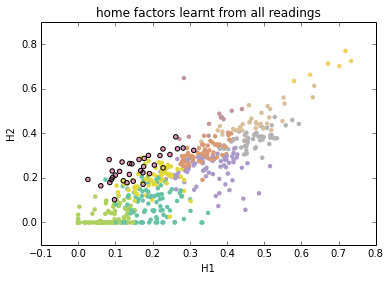

In [348]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

start = len(tensor)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from all readings")

target_cluster_id = 4
target_cluster_idx = [i for i, j in enumerate(cluster) if j == target_cluster_id]
ax.scatter(X[target_cluster_idx, x1], X[target_cluster_idx, x2], color='black', marker='o', facecolors='none')
print len(target_cluster_idx)

In [335]:
len(target_cluster_idx)

34

In [146]:
import random
random.seed(10)
random.shuffle(target_cluster_idx)
test_idx = target_cluster_idx[:6]
validate_idx = target_cluster_idx[6:12]
test_validate_idx = np.r_[test_idx, validate_idx]
train_idx = list(set(list(range(533))) - set(test_validate_idx))

In [147]:
train_ix = df.index[train_idx]
test_ix = df.index[test_idx]
validate_ix = df.index[validate_idx]
idx = np.r_[test_ix, validate_ix, train_ix]
df_t = df.loc[idx]
tensor = get_tensor(df_t, 1, 13)
L_inner = L[np.ix_(np.r_[test_validate_idx, train_idx], np.r_[test_validate_idx, train_idx])]

In [148]:
from sklearn.metrics.pairwise import cosine_similarity

In [174]:
num_home_factor = 3
num_season_factor = 3

num_test = len(test_ix)
num_validate = len(validate_ix)
num_train = len(train_ix)

num_iterations = 20

train_df = df.loc[train_ix]
test_validate_df = df.loc[np.r_[test_ix, validate_ix]]

train_tensor = get_tensor(train_df, 1, 13)
test_validate_tensor = get_tensor(test_validate_df, 1, 13)

L_train = L[np.ix_(train_idx, train_idx)]
L_test_validate = L[np.ix_(test_validate_idx, test_validate_idx)]


weight_matrices = {}
train_weight = np.ones(train_tensor.shape)

H = {}

pred = {}
for iterations in range(num_iterations):
    pred[iterations] = {}
    for appliance in APPLIANCES_ORDER:
        pred[iterations][appliance] = []

tv_weight = np.ones(test_validate_tensor.shape)
print tv_weight.shape

for iteration in range(num_iterations):
    print "iteration: ", iteration
    
    weight_matrices[iteration] = train_weight
    tensor_copy = train_tensor.copy()

    # do tensor factorization
    H_train, A_train, T_train, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                               L_train,
                                                              num_home_factor,
                                                              num_season_factor,
                                                             train_weight,
                                                              num_iter=3000,
                                                              lr=0.1, dis=True,
                                                              lam=0,
                                                              T_known=T_constant)

    # use A, T to learn Home factors of validate and test homes
    tensor_copy = test_validate_tensor.copy()
    print tensor_copy.shape
    
    
    H_tv, A_tv, T_tv, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L_test_validate,
                                                                       num_home_factor, num_season_factor, tv_weight,
                                                                       num_iter=3000, lr=0.1, dis=True, lam=0,
                                                                       A_known=A_train, T_known=T_train)
    
    HAT = multiply_case(H_tv, A_tv, T_tv, 2)
    for appliance in APPLIANCES_ORDER:
        pred[iteration][appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index = test_ix))
                
    # use the Home factors to update the weight matrix
    H_validate = H_tv[num_test:]
    
    H_validate_train = np.r_[H_validate, H_train]
    similarities = cosine_similarity(H_validate_train)
    sim = similarities[num_validate:, :num_validate]
    sim = sim.max(axis=1)
    sim = (sim - sim.min())/(sim.max() - sim.min())
    print len
    train_weight = np.repeat(sim.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
    print train_weight.shape
    
    # store the home factors
    H[iteration] = np.r_[H_tv, H_train]
    

(12, 7, 12)
iteration:  0
495.121788335
136.296345885
96.2492772186
90.3629294335
84.2626776822
80.3073820296
(12, 7, 12)
567.999389682
183.251481819
162.364909884
155.850923172
151.363262318
148.011823978
<built-in function len>
(521, 7, 12)
iteration:  1
458.894929231
124.876143505
86.9143167001
81.7684557024
76.9241890194
73.2064173488
(12, 7, 12)
565.466860663
174.491320344
156.616703608
151.332440887
147.835710548
145.346584079
<built-in function len>
(521, 7, 12)
iteration:  2
444.074994255
121.068747539
84.0851309977
78.927160282
74.3932144773
70.9641078757
(12, 7, 12)
564.474460102
170.597532296
153.766581827
148.943118981
145.844286177
143.706560106
<built-in function len>
(521, 7, 12)
iteration:  3
448.876876899
123.015091296
85.6570525435
80.3860667505
75.5260130156
72.0660628556
(12, 7, 12)
564.871402044
171.671966417
154.341261332
149.334295534
146.104211491
143.864903292
<built-in function len>
(521, 7, 12)
iteration:  4
443.224472291
120.99152997
84.0263005143
78.8701781

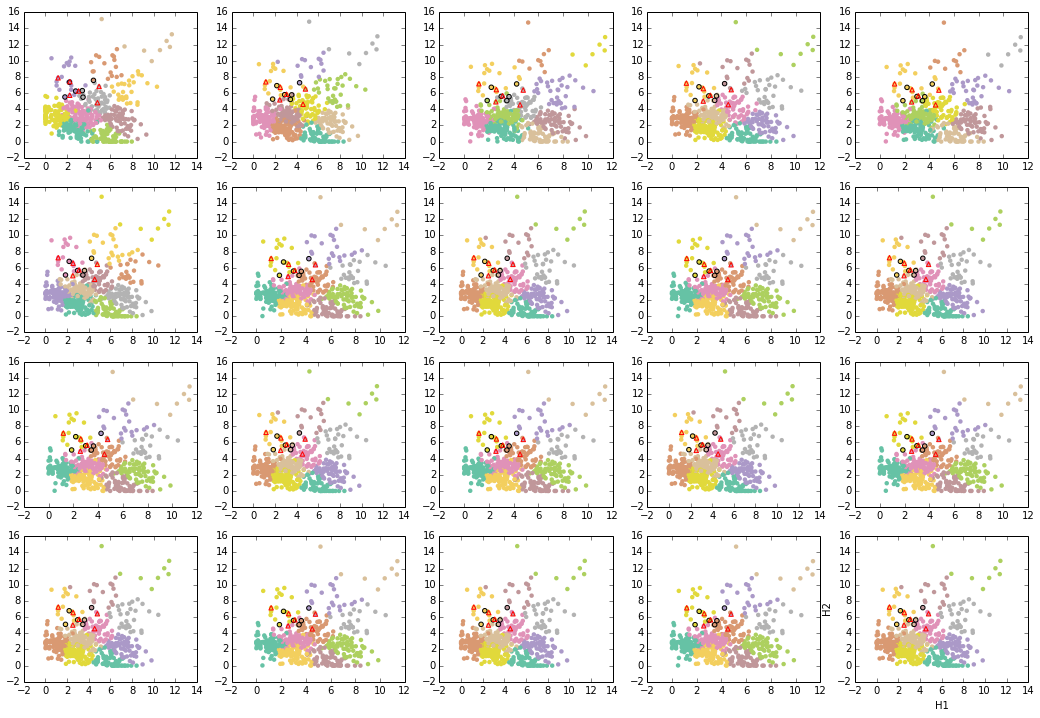

In [313]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18,12))

for iteration in range(num_iterations):
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0

    axes[iteration/5][iteration%5].scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
    axes[iteration/5][iteration%5].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    axes[iteration/5][iteration%5].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

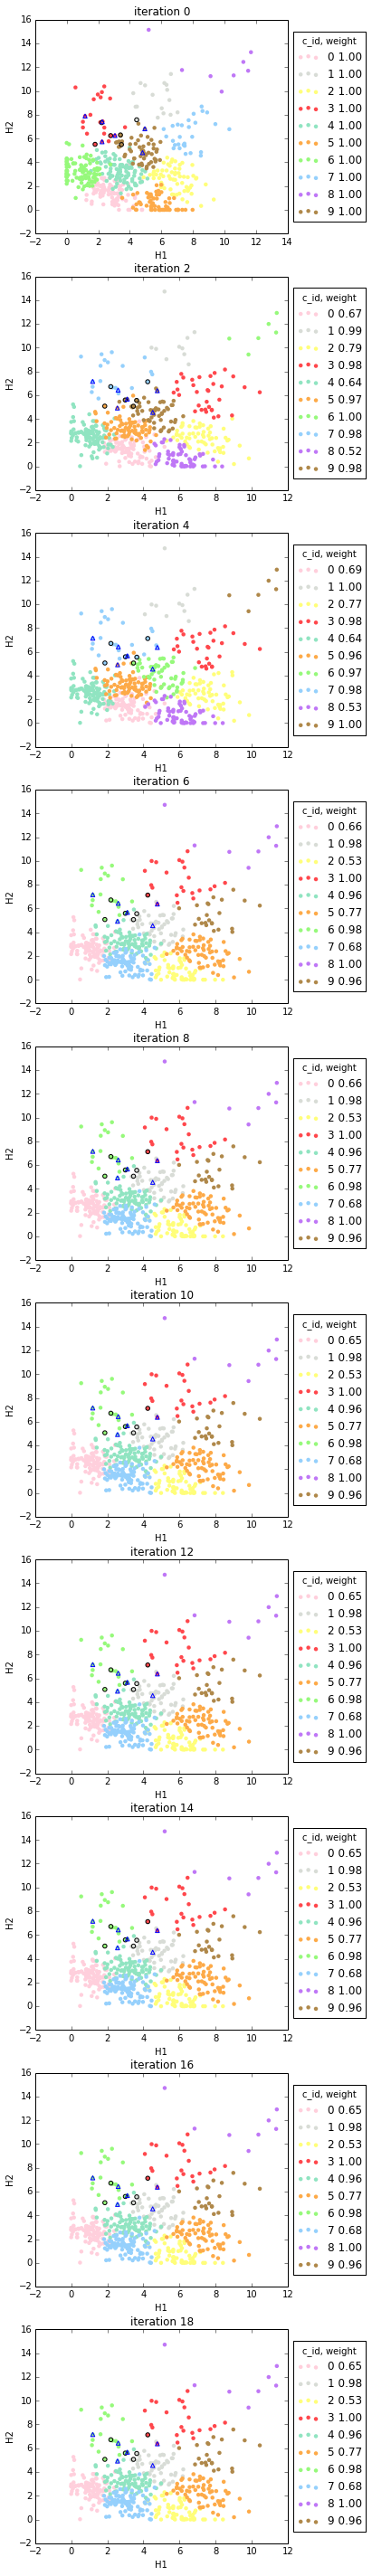

In [316]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

colors = ['#ffcfdc', '#d8dcd6', '#fffe7a', '#ff474c', '#90e4c1', '#fdaa48', '#96f97b', '#95d0fc', '#bf77f6', '#af884a']
for iteration in range(0, num_iterations, 2):
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
    
    for c_id in set(cluster):
        
        sub_cluster = sim_df.loc[sim_df[0] == c_id]
        mean_sim = format(sub_cluster[1].mean(axis=0), '.2f')
        
        index = [i for i,j in enumerate(cluster) if j == c_id]
        axes[iteration/2].scatter(X[index, x1], X[index, x2], c = colors[c_id], lw=0, label="{} {}".format(c_id, mean_sim))
    axes[iteration/2].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    axes[iteration/2].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='blue', marker='^', facecolors='none')
    axes[iteration/2].set_xlabel("H1")
    axes[iteration/2].set_ylabel("H2")
    axes[iteration/2].set_title("iteration {}". format(iteration))
    axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

In [222]:
for iteration in [1]:
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
#     print sim_df
    for i in set(cluster):
        print i
        sub_cluster = sim_df.loc[sim_df[0] == i]
#         print sub_cluster[1]
        print sub_cluster[1].mean(axis=0)
    

0
0.622840168153
1
0.759571503338
2
0.974465824913
3
0.994532812812
4
0.71764788086
5
0.987875947028
6
0.984631303924
7
0.982822854796
8
0.851112883496
9
0.995633613401


In [291]:
out = {}
for iteration in range(num_iterations):
    out[iteration] = {}
    for appliance in APPLIANCES_ORDER[1:]:
        s = pd.concat(pred[iteration][appliance]).loc[test_ix]
        if appliance=="hvac":
            out[iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
        else:   
            out[iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

In [300]:
pd.DataFrame(out)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dw,0.887306,0.869257,0.869078,0.871891,0.869763,0.871218,0.869745,0.871287,0.869730,0.871051,0.869741,0.871085,0.869741,0.871085,0.869741,0.871033,0.869741,0.871031,0.869742,0.871032
fridge,2.331849,2.585163,2.674884,2.638866,2.672606,2.641587,2.665166,2.641566,2.665147,2.641609,2.665233,2.641524,2.665298,2.641437,2.665354,2.641358,2.665403,2.641291,2.665443,2.641237
hvac,8.947893,7.981486,7.464093,7.526313,7.426530,7.610253,7.446181,7.611721,7.446162,7.611764,7.445780,7.611943,7.445692,7.612095,7.445636,7.612191,7.445599,7.612273,7.445571,7.612320
mw,0.545434,0.607760,0.624741,0.612283,0.624145,0.612163,0.622240,0.612434,0.622119,0.612478,0.622143,0.612452,0.622159,0.612435,0.622169,0.612424,0.622177,0.612416,0.622183,0.612414
oven,0.505874,0.490059,0.482211,0.488351,0.482154,0.488315,0.482567,0.487928,0.482578,0.487923,0.482575,0.487928,0.482579,0.487927,0.482581,0.487927,0.482578,0.487924,0.482577,0.487923
wm,0.178933,0.201242,0.208063,0.206522,0.208343,0.205590,0.207776,0.205613,0.207743,0.205627,0.207755,0.205623,0.207758,0.205618,0.207760,0.205615,0.207762,0.205611,0.207764,0.205609


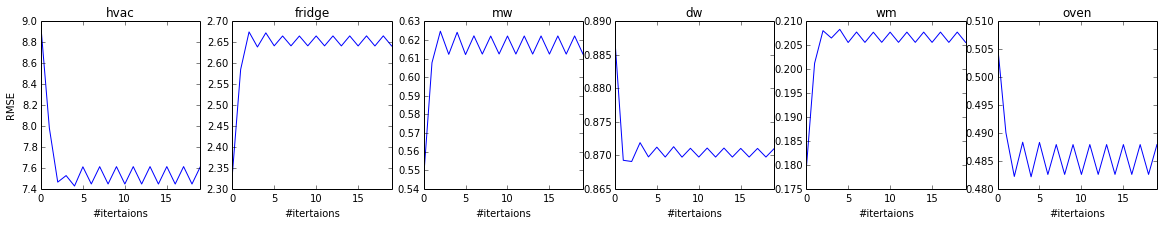

In [323]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out = pd.DataFrame(out)

for appliance in APPLIANCES_ORDER[1:]:
    mean_out.T[appliance].plot(ax = ax[count], title=appliance)
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
plt.savefig("appliance-RMSE_test.pdf", format='pdf')

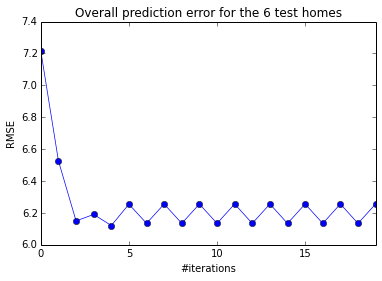

In [325]:
fig, ax = plt.subplots()
error = (mean_out.T*pd.Series(contri['Austin'])).sum(axis=1)
error.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes")
plt.savefig("overall-RMSE_test.pdf", format='pdf')

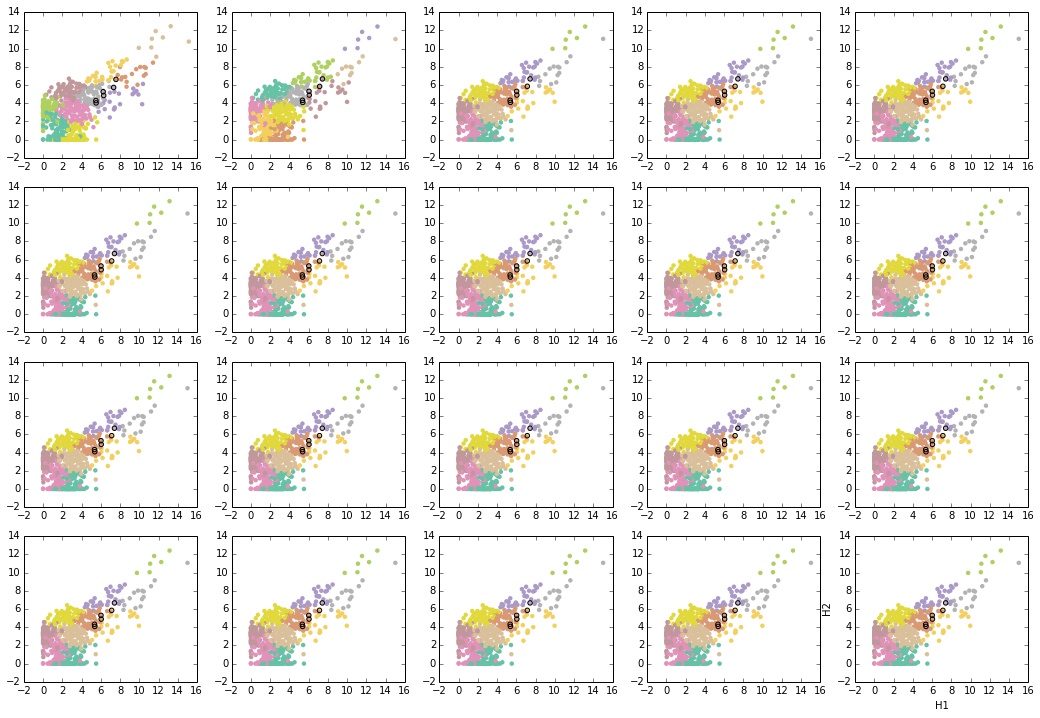

In [165]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18,12))

for iteration in range(num_iterations):
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]

    axes[iteration/5][iteration%5].scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
    axes[iteration/5][iteration%5].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
#     plt.title("home factors learnt from aggregate readings")

In [158]:
print H[0][0]
print H[1][0]

[ 6.30419716  4.84386251  3.40501144]
[ 6.06741373  4.8919832   3.46074237]


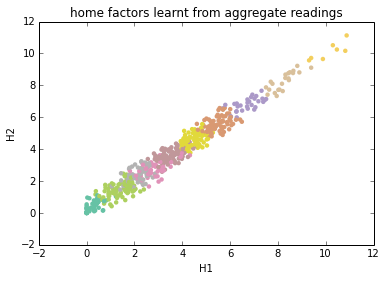

In [109]:
X = H[2]
cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
x1, x2 = (-np.var(X, axis=0)).argsort()[:2]


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
# ax.scatter(X[start:, x1], X[start:, x2], color='black', marker='o', facecolors='none')
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from aggregate readings")
